In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
rng = np.random.default_rng()

## chapter 1
### 1. 
generate spikes for 10s using a Poisson spike generator with a constant rate of 100Hz and record their times of occurrence
compute the coefficient of variation of the interspike intervals, and the Fano factor for the spike counts obtained over conting intervals ranging from 1 to 100ms.
plot the ISI histogram

In [47]:
T = 100 # total time, seconds
r = 100 # firing rate, Hz
dt = 1e-3 # timestep, seconds
tmax = int(T/dt) # max time 
t = np.arange(0, tmax) # time vector
rt = dt * r # time dependent firing rate


In [48]:
# generate spikes
spikes = rng.poisson(lam=rt, size=tmax)
spikes[spikes > 1] = 1
# get spike times
spike_times = np.where(spikes)[0]
# get ISI
isi = np.diff(spike_times)

In [49]:
# get coefficient variation
mean_isi = np.mean(isi)
std_isi = np.std(isi)
c_v = std_isi / mean_isi
print(f'Coefficient of variation is: {c_v}')

def get_fano_factor(spikes, window_size):
    """returns fano factor for spike"""
    counts = []
    for i in range(1, int(len(spikes) / window_size + 1)):
        counts.append(sum(spikes[(i - 1) * window_size: (i * window_size)]))

    return np.var(counts) / np.mean(counts)

fano_factors = []
for i in range(1, 101):
    fano_factors.append(get_fano_factor(spikes, i))

Coefficient of variation is: 0.9643102244906857


(0.0, 0.9945721191036949)

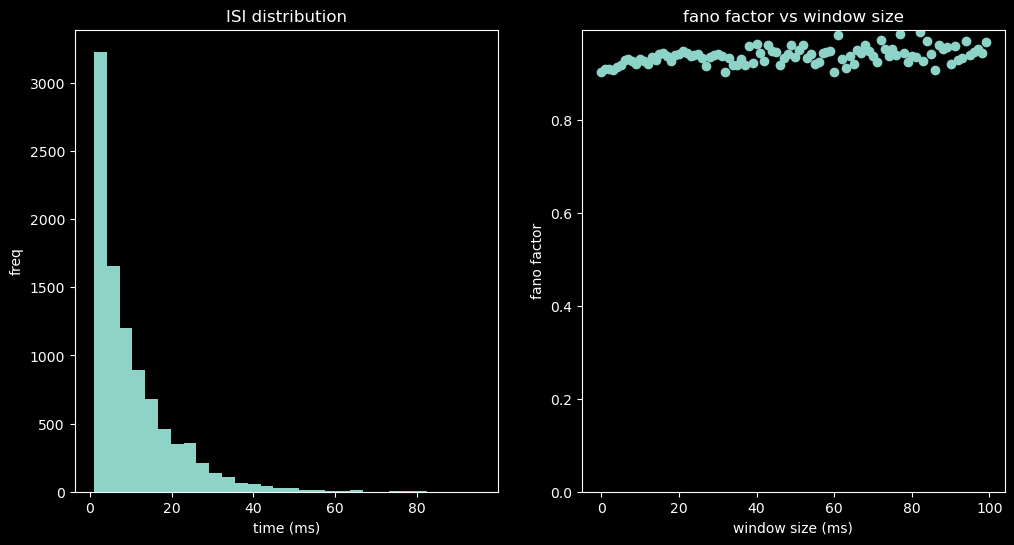

In [50]:
# plot ISI 
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(isi, bins=30)
ax[0].set_title('ISI distribution')
ax[0].set_xlabel('time (ms)')
ax[0].set_ylabel('freq')

ax[1].scatter(np.arange(0, 100, 1), fano_factors)
ax[1].set_title('fano factor vs window size')
ax[1].set_xlabel('window size (ms)')
ax[1].set_ylabel('fano factor')
ax[1].set_ylim(bottom=0)

## 2.
add a refractory period to the Poisson spike generator by allowing the firing rate to depend on time.
- initially, set firing rate to constant value $r(t) = r_0$
- after every spike, set $r(t)$ to 0, and allow it to recover exponentially back to $r_0$ with a time constant $\tau_{ref}$ that controls the refractory rate
- have $r(t)$ obey:
$
\tau_{ref}\frac{dr}{dt} = r_0 - r
$
except immediately after a spike, when it is set to 0.

- plot the coefficient of variation as a function of $\tau_{ref}$ over the range $1\text{ms} \leq \tau_{ref} \leq 20\text{ms}$
- plot ISI histograms for different values of $\tau_{ref}$ in this range
- compute fano factor for spike counts obtained over counting intervals ranging from 1 to 100ms for the case $\tau_{ref}$ = 10ms

In [51]:
r0 = 100 # initial firing rate, Hz

def drdt(r, r0, tau_ref, dt):
    """updates spike generating equation"""
    drdt = (r0 - r) / tau_ref
    return drdt * dt

# initialize firing rate array
r = np.zeros_like(t)
r[0] = r0

# generate spikes function
def refractoriness_spikes(tmax, dt, tau_ref, r0):
    """ generates poisson process spikes with refractoriness"""
    r = np.zeros(tmax)
    r[0] = r0
    # create empty spike vector
    spikes = np.zeros(tmax)
    # iterate through time
    for i in range(1, tmax - 1):
        # if spike condition
        if rng.poisson(lam=r[i - 1]*dt, size=1) > 0:
            # append spike
            spikes[i] = 1
            # set firing rate to 0
            r[i+1] = 0
        else:
            # decay to steady state 
            r[i+1] += drdt(r[i], r0, tau_ref, dt)
    return spikes

# coefficient of variation function
def get_cv(isi):
    return np.std(isi)/np.mean(isi)

In [52]:
tau_ref_list = []
isi_list = []
cv_list = []
for i in range (1, 21):
    tau_ref = i * 1e-3
    tau_ref_list.append(tau_ref)
    spikes = refractoriness_spikes(tmax, dt, tau_ref, r0)
    spike_times = np.where(spikes)[0] * dt
    isi = np.diff(spike_times)
    isi_list.append(isi)
    cv_list.append(get_cv(isi))

In [53]:
# for case where t_ref = 10
tau_ref = 10e-3
spikes = refractoriness_spikes(tmax, dt, tau_ref, r0)

fano_factors = []
for i in range(1, 101):
    fano_factors.append(get_fano_factor(spikes, i))

spike_times = np.where(spikes)[0] * dt
isi = np.diff(spike_times)

(0.0, 1.01345191628564)

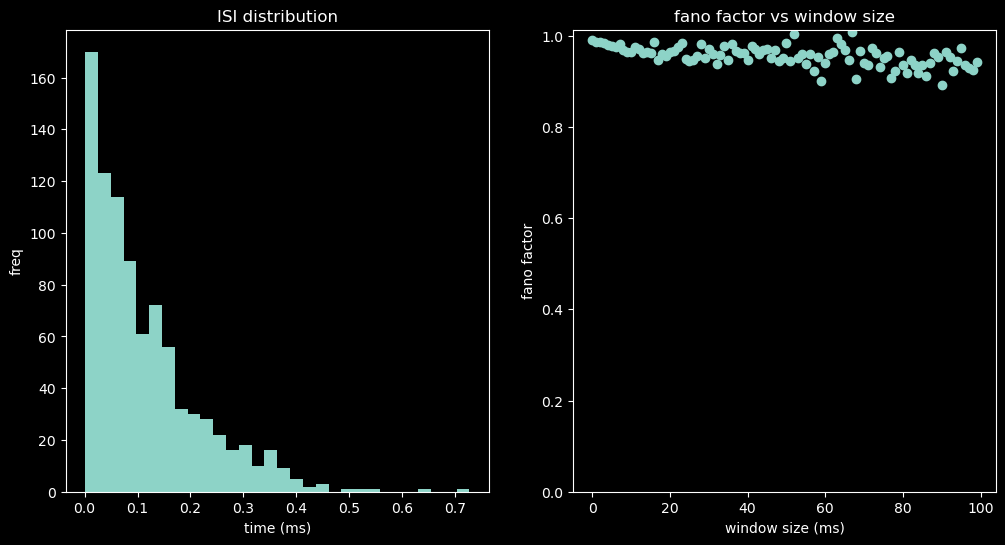

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(isi, bins=30)
ax[0].set_title('ISI distribution')
ax[0].set_xlabel('time (ms)')
ax[0].set_ylabel('freq')

ax[1].scatter(np.arange(0, 100, 1), fano_factors)
ax[1].set_title('fano factor vs window size')
ax[1].set_xlabel('window size (ms)')
ax[1].set_ylabel('fano factor')
ax[1].set_ylim(bottom=0)


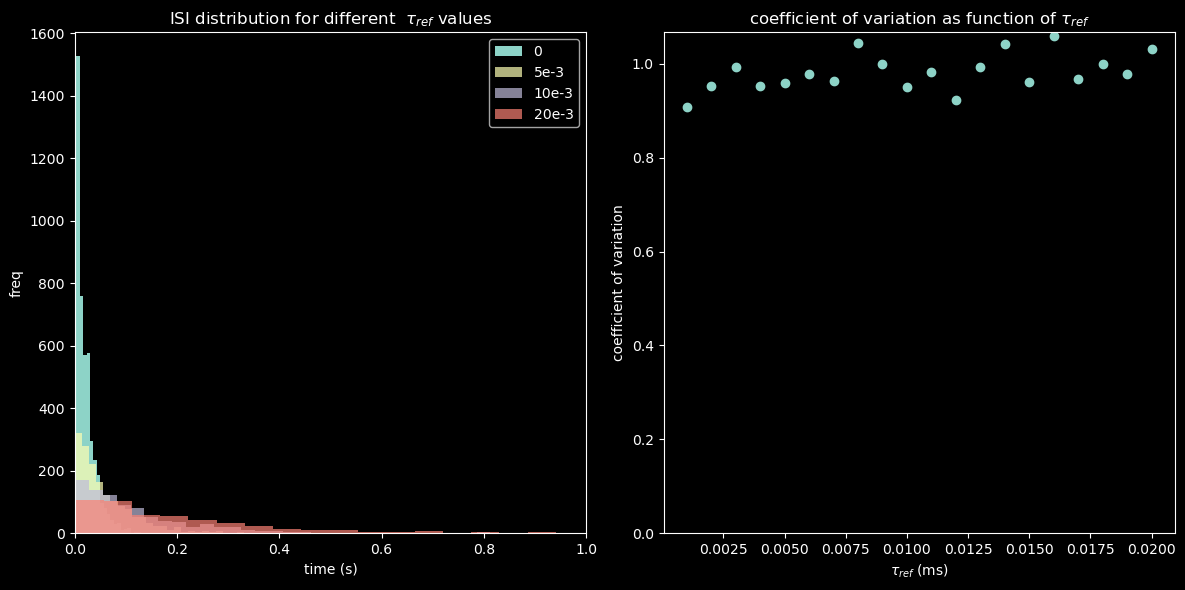

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(isi_list[0],  bins=30, label='0')
ax[0].hist(isi_list[4],  bins=30, label='5e-3', alpha=0.7)
ax[0].hist(isi_list[9],  bins=30, label='10e-3', alpha=0.7)
ax[0].hist(isi_list[19], bins=30, label='20e-3', alpha=0.7)
ax[0].set_title('ISI distribution for different  ' r'$\tau_{ref}$ values')       
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('freq')    
ax[0].set_xlim(0, 1)
ax[0].legend()

ax[1].scatter(tau_ref_list, cv_list)
ax[1].set_title('coefficient of variation as function of 'r'$\tau_{ref}$')
ax[1].set_xlabel(r'$\tau_{ref}$ (ms)')
ax[1].set_ylabel('coefficient of variation')
ax[1].set_ylim(bottom=0)

plt.tight_layout()

## 3.
compute autocorrelation histograms of spike trains geerated by a Poisson generator with:
- constant firing rate of 100 Hz
- constant firing rate of 100 Hz with refractory period modeled as q2 with $\tau_{ref}$ = 10ms
- variable firing rate:
$r(t) = 100(1 +\cos(2\pi t / 300ms))$ Hz

plot histograms over range from 0 to 100ms

### constant 100hz firing rate

In [56]:
T = 100 # total time, seconds
r = 100 # firing rate, Hz
dt = 1e-3 # timestep, seconds
tmax = int(T/dt) # max time 
t = np.arange(0, tmax) # time vector
rt = dt * r # time dependent firing rate

# generate spikes
spikes = rng.poisson(lam=rt, size=tmax)
spikes[spikes > 1] = 1
# get spike times
spike_times = np.where(spikes)[0]
# get ISI
isi = np.diff(spike_times)

In [57]:
def autocorrelation(spike_train):
    result = np.correlate(spike_train, spike_train, mode='full')
    # autocorrelation is symmetric, so only keep positive time lags
    return result#[result.size // 2:]

In [58]:
autocorr1 = autocorrelation(spikes)
lags = np.arange(-len(autocorr1) // 2 + 1, len(autocorr1) // 2 + 1) * dt

Text(0, 0.5, 'autocorrelation')

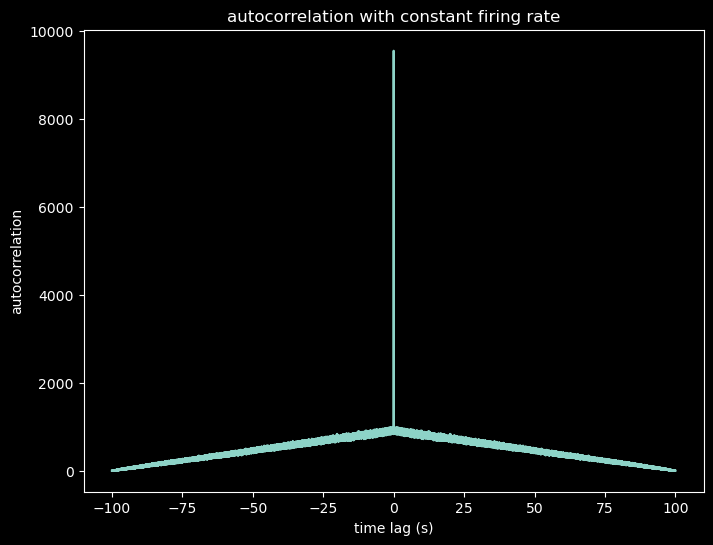

In [59]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(lags, autocorr1)
ax.set_title('autocorrelation with constant firing rate')
ax.set_xlabel('time lag (s)')
ax.set_ylabel('autocorrelation')


### refractory and constant 100hz

In [60]:
# for case where t_ref = 10
tau_ref = 10e-3
spikes = refractoriness_spikes(tmax, dt, tau_ref, r0)

autocorr2 = autocorrelation(spikes)
lags = np.arange(-len(autocorr2) // 2 + 1, len(autocorr2) // 2 + 1) * dt


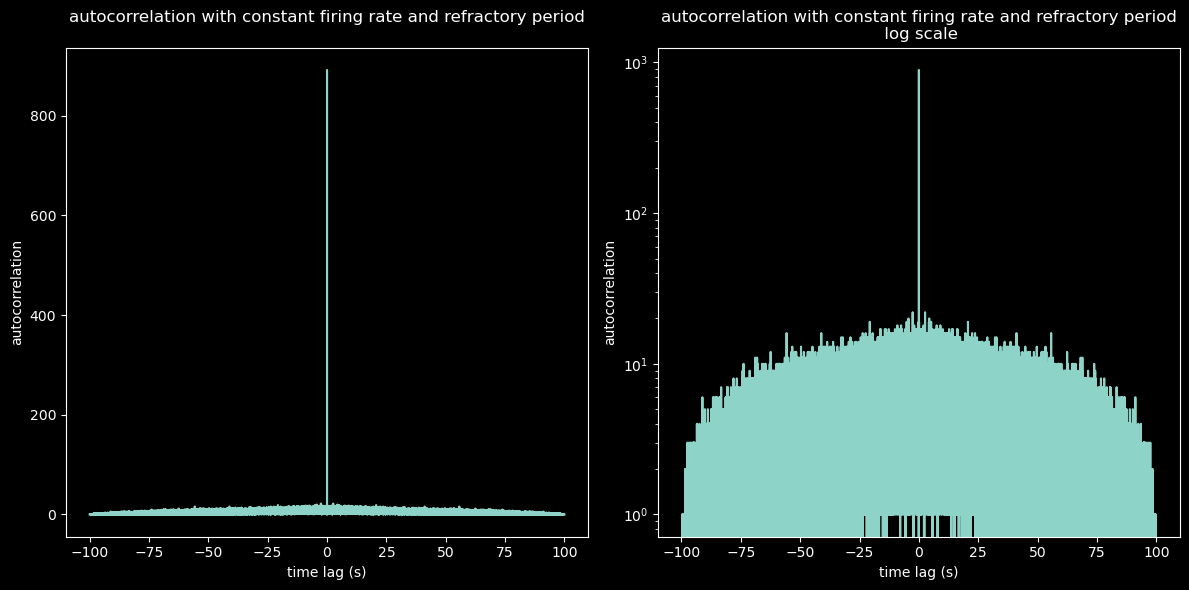

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(lags, autocorr2)
ax[0].set_title('autocorrelation with constant firing rate and refractory period\n')
ax[0].set_xlabel('time lag (s)')
ax[0].set_ylabel('autocorrelation')

ax[1].plot(lags, autocorr2)
ax[1].set_title('autocorrelation with constant firing rate and refractory period\n log scale')
ax[1].set_xlabel('time lag (s)')
ax[1].set_ylabel('autocorrelation')
ax[1].set_yscale('log')

plt.tight_layout()

### variable firing rate

In [62]:
def variable_drdt(t):
    return 100 * (1 + np.cos(2 * np.pi * t*dt / 25e-3))

def variable_spikes(tmax, dt):
    r = np.zeros(tmax)
    r[0] = 100
    spikes = np.zeros(tmax)
    t = np.arange(0, tmax)

    for i in range(1, tmax-1):
        if rng.poisson(lam=r[i-1]*dt, size=1) > 0:
            spikes[i] = 1
        r[i] += variable_drdt(t[i])

    return spikes


In [63]:
spikes = variable_spikes(tmax, dt)
autocorr3 = autocorrelation(spikes)
lags = np.arange(-len(autocorr3) // 2 + 1, len(autocorr3) // 2 + 1) * dt


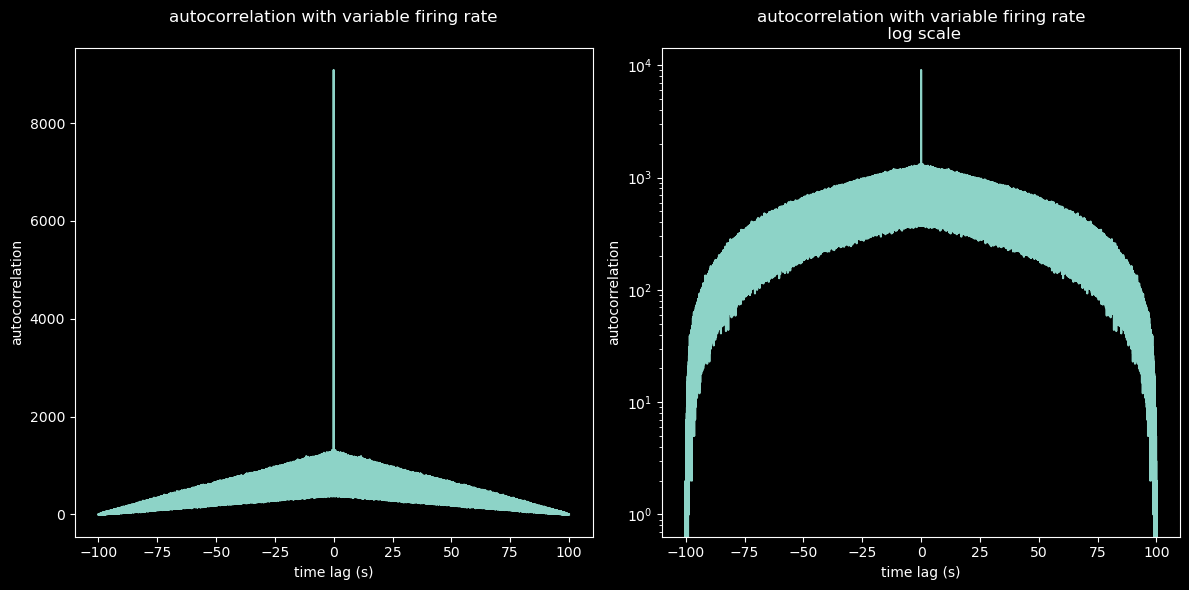

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(lags, autocorr3)
ax[0].set_title('autocorrelation with variable firing rate\n')
ax[0].set_xlabel('time lag (s)')
ax[0].set_ylabel('autocorrelation')

ax[1].plot(lags, autocorr3)
ax[1].set_title('autocorrelation with variable firing rate\n log scale')
ax[1].set_xlabel('time lag (s)')
ax[1].set_ylabel('autocorrelation')
ax[1].set_yscale('log')

plt.tight_layout()

Text(0.5, 1.0, 'autocorrelation with variable firing rate')

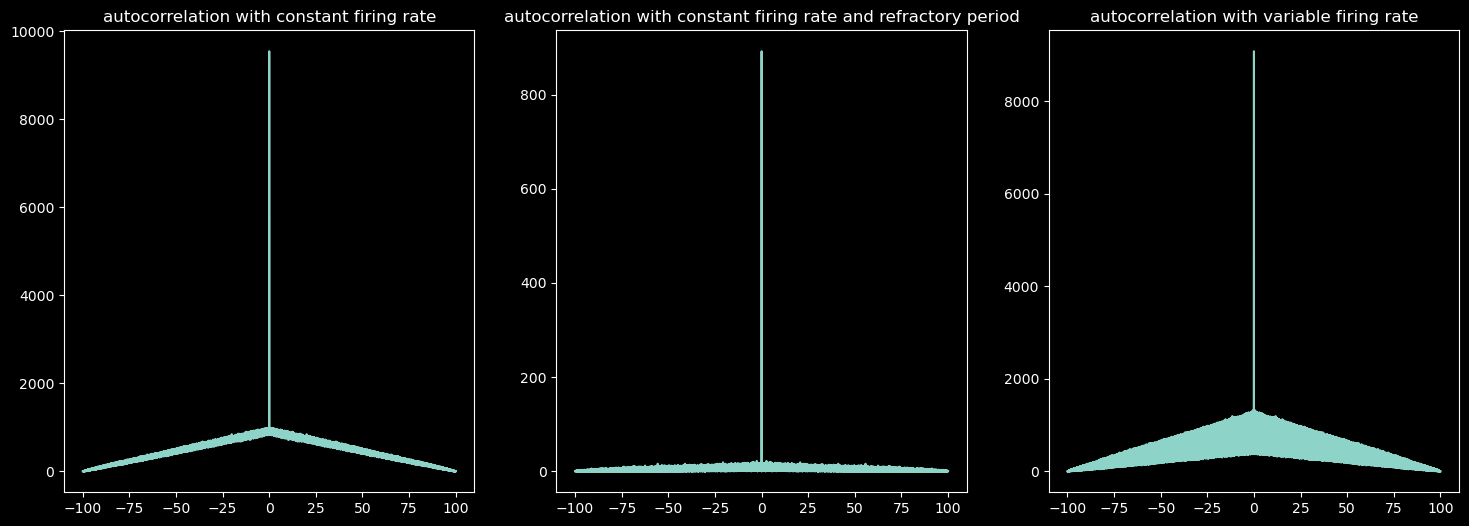

In [65]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].plot(lags, autocorr1)
ax[1].plot(lags, autocorr2)
ax[2].plot(lags, autocorr3)

ax[0].set_title('autocorrelation with constant firing rate')
ax[1].set_title('autocorrelation with constant firing rate and refractory period')
ax[2].set_title('autocorrelation with variable firing rate')

In [66]:
# get autocorrelation values for only positive lags
pos1 = autocorr1[int(np.ceil(autocorr1.size/2)):][0:100]
pos2 = autocorr2[int(np.ceil(autocorr2.size/2)):][0:100]
pos3 = autocorr3[int(np.ceil(autocorr3.size/2)):][0:100]

x = np.linspace(1, len(pos1), len(pos1))
x3 = np.linspace(1, len(pos3), len(pos3))

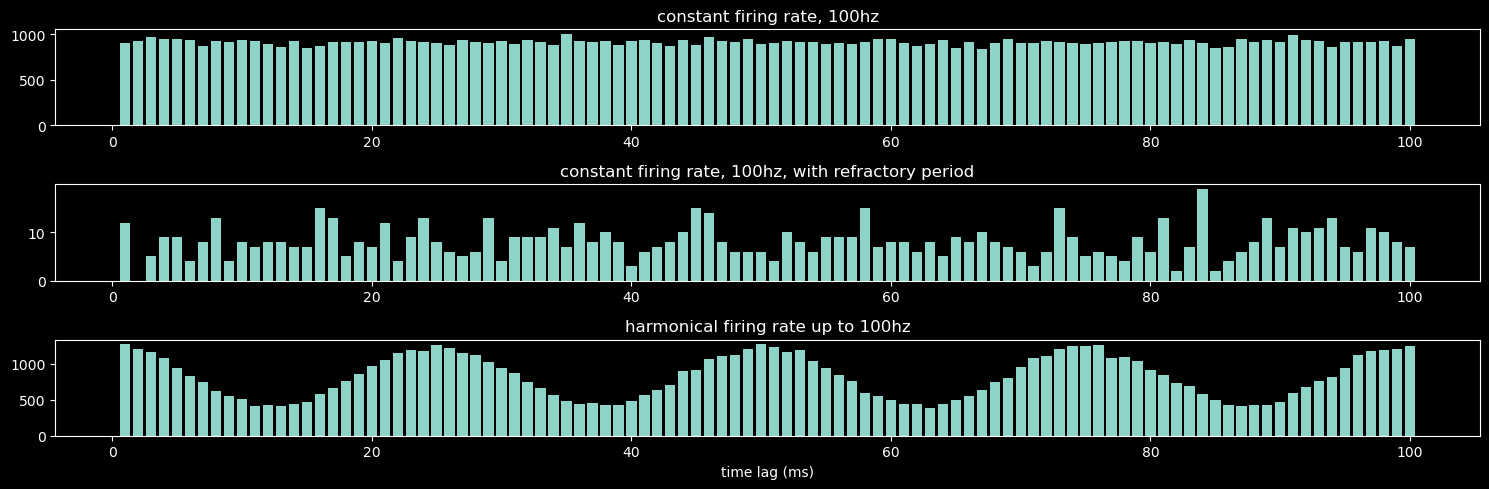

In [68]:
fig, ax = plt.subplots(3, 1, figsize=(15, 5))

ax[0].bar(x, pos1)
ax[0].set_title('constant firing rate, 100hz')
ax[1].bar(x, pos2)
ax[1].set_title('constant firing rate, 100hz, with refractory period')
ax[2].bar(x3, pos3)
ax[2].set_title('harmonical firing rate up to 100hz')

ax[2].set_xlabel('time lag (ms)')

plt.tight_layout()

## 4
generate a poisson spike train with a time-dependent firing rate
$ r(t) = 100(1 + \cos(2 \pi t / 300\text{ms})) $ Hz

approximate the firing rate from this spike train using a variable $r_{approx}$ that satisfies 
$ \tau_{approx} \frac {d r_{approx}}{dt} = -r_{approx} $

except that $r_{approx} \rightarrow r_{approx} + 1/ \tau_{approx} $ every time a spike occurs

make plots of:
    - true rate
    - spike sequence generated
    - estimated rate

experiment with different values of $\tau_{approx}$ in the range of 1 to 100ms

determine the best value of $\tau_{approx}$ by computing the average squared error of the estimate:


$\int dt(r(t) - r_{approx}(t))^2$ for different values of $\tau_{approx}$ and finding the value of $\tau_{approx}$ that minimizes this error

In [166]:
T = 10  # seconds
tmax = int(T/dt)
dt = 1e-3   # timestep, seconds
t = np.arange(0, tmax)

def variable_drdt(t):
    return 100 * (1 + np.cos(2 * np.pi * t*dt / 300e-3))

def variable_spikes(tmax, dt):
    r = np.zeros(tmax)
    r[0] = 100
    spikes = np.zeros(tmax)

    for i in range(1, tmax-1):
        if rng.poisson(lam=r[i-1]*dt, size=1) > 0:
            spikes[i] = 1
        r[i] += variable_drdt(t[i])

    return spikes

spikes = variable_spikes(tmax, dt)

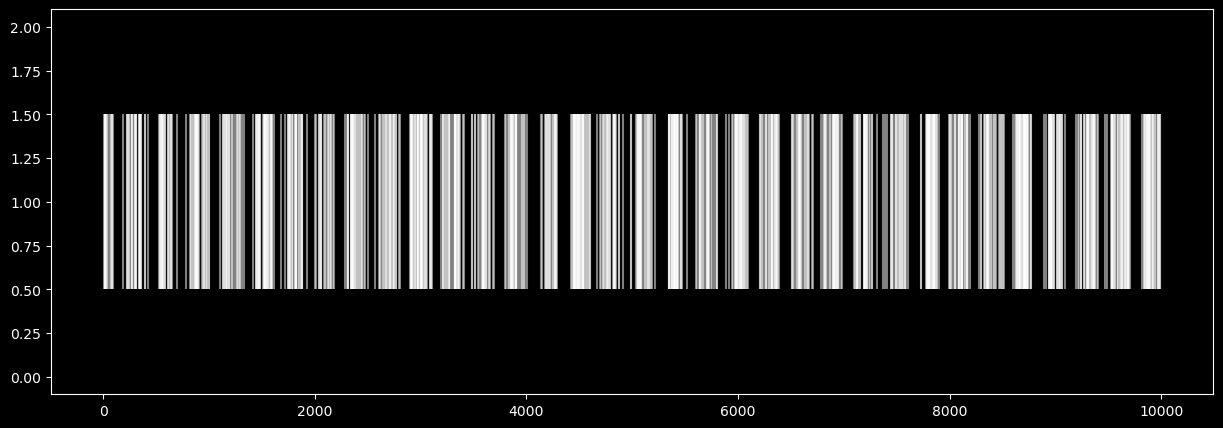

In [287]:
# visualize spikes 
spike_times = np.where(spikes)
spike_times = np.asarray(spike_times[0])
fig, ax = plt.subplots(figsize=(15, 5))
ax.eventplot(spike_times, alpha=0.5)

In [288]:
def get_r_approx(spikes, dt, tau_approx):
    """calculate approx firing rate from spike train"""
    r_approx = np.zeros_like(spikes)

    for i in range(1, len(spikes)):
        spike_contribution = 1 / tau_approx if spikes[i] > 0 else 0
        r_approx[i] = r_approx[i - 1] * np.exp(-dt / tau_approx) + spike_contribution
    return r_approx

In [289]:
tau_vals = np.arange(1e-3, 111e-3, 10e-3)

r_approx_list = []

for tau in tau_vals:
    r_approx_list.append(get_r_approx(spikes, dt, tau))

In [290]:
df = pd.DataFrame(zip(tau_vals, r_approx_list))
df.rename(columns={0: 'tau', 1: 'r_approx'}, inplace=True)

In [291]:
true_rate = variable_drdt(t)

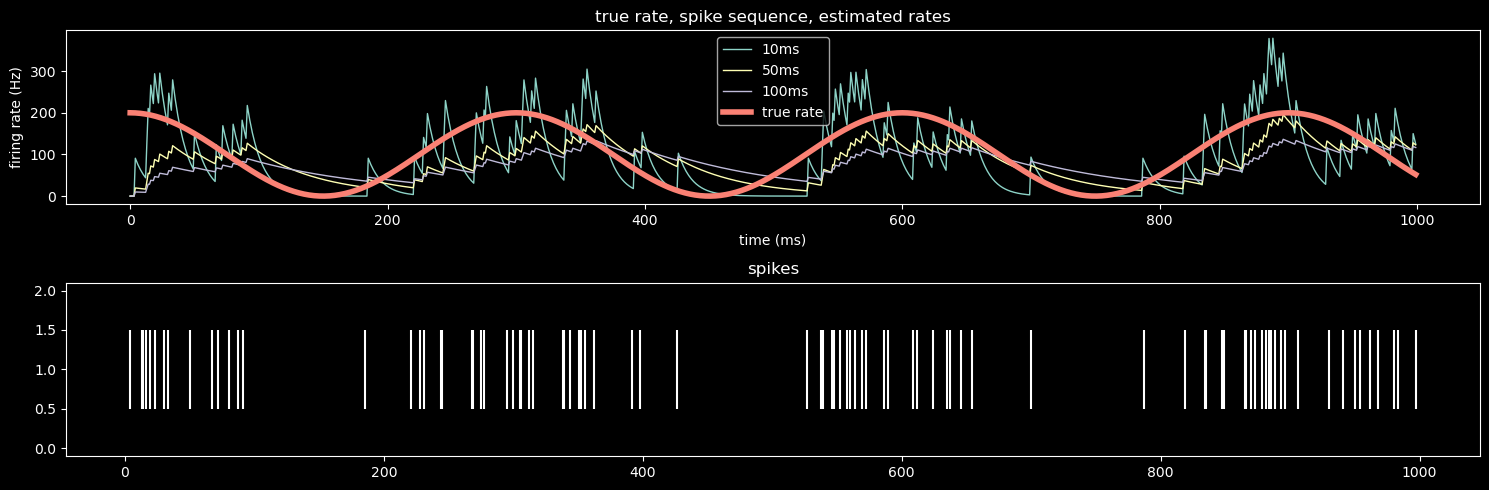

In [292]:
fig, ax = plt.subplots(2, 1, figsize=(15, 5))

ax[0].plot(df['r_approx'][1][:1000], linewidth=1, label='10ms')
ax[0].plot(df['r_approx'][5][:1000], linewidth=1, label='50ms')
ax[0].plot(df['r_approx'][10][:1000], linewidth=1, label='100ms')
ax[0].plot(true_rate[:1000], linewidth=4, label='true rate')

ax[0].set_ylabel('firing rate (Hz)')
ax[0].set_xlabel('time (ms)')
ax[0].set_title('true rate, spike sequence, estimated rates')

ax[1].eventplot(spike_times[:88])  # to get x axes to line up
ax[1].set_title('spikes')

ax[0].legend()

plt.tight_layout()

In [320]:
df['square_error'] = df['r_approx'].apply(lambda r: np.sum((r - true_rate) ** 2))
print(f"value of tau best approximating firing rate is: {np.round(df.loc[df['square_error'].idxmin(), 'tau'], 2)} s")

value of tau best approximating firing rate is: 0.03 s


Text(0, 0.5, 'square error')

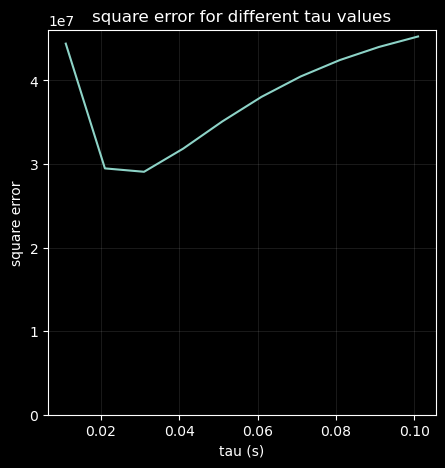

In [338]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(df['tau'][1:], df['square_error'][1:])
ax.set_ylim(0)
ax.grid(which='both', alpha=0.1)
ax.set_title('square error for different tau values')
ax.set_xlabel('tau (s)')
ax.set_ylabel('square error')